In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)  # Should print the installed TensorFlow version

2.18.0


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, Flatten, Dropout, Input, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
import keras_tuner as kt
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
data = pd.read_excel("/content/drive/MyDrive/dataset(2014-2022).xlsx")

In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,Female,NaN,No,Yes,Often,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,M,NaN,No,No,Rarely,More than 1000,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,Male,NaN,No,No,Rarely,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,Male,NaN,Yes,Yes,Often,26-100,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,Male,NaN,No,No,Never,100-500,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
data.shape

(4692, 17)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4692 entries, 0 to 4691
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4690 non-null   float64
 1   Gender                   4658 non-null   object 
 2   self_employed            4674 non-null   object 
 3   family_history           4692 non-null   object 
 4   treatment                4692 non-null   object 
 5   work_interfere           4428 non-null   object 
 6   no_employees             4106 non-null   object 
 7   tech_company             4086 non-null   object 
 8   benefits                 4086 non-null   object 
 9   seek_help                3247 non-null   object 
 10  anonymity                4086 non-null   object 
 11  coworkers                4201 non-null   object 
 12  supervisor               4204 non-null   object 
 13  mental_health_interview  4692 non-null   object 
 14  phys_health_interview   

In [ ]:
data.isnull().sum()

,0
Age,2
Gender,34
self_employed,18
family_history,0
treatment,0
work_interfere,264
no_employees,586
tech_company,606
benefits,606
seek_help,1445


In [ ]:
data.fillna(method='ffill', inplace=True)

<ipython-input-11-519281724d28>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
print("\nNull Values After Filling:")
print(data.isnull().sum())


Null Values After Filling:
Age                         0
Gender                      0
self_employed              18
family_history              0
treatment                   0
work_interfere              0
no_employees                0
tech_company                0
benefits                    0
seek_help                   0
anonymity                   0
coworkers                   0
supervisor                  0
mental_health_interview     0
phys_health_interview       0
mental_vs_physical          0
leave                       0
dtype: int64


In [ ]:
# Display unique gender categories
print("Unique Gender Categories Before Cleaning:")
print(data['Gender'].unique())

Unique Gender Categories Before Cleaning:
['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means'
 'I identify as female.' 'female ' 'Bigender' 'Female assigned at birth '
 'man' 'fm' 'Cis female ' 'Transitioned, M2F' 'Genderfluid (born female)'
 'Other/Transfeminine' 'Female or Multi-Gender Femme' 'female/woman'
 'Cis male' 'Male.' 'Androgynous' 'male 9:1 female, roughly' 'Male (cis)'
 'Other' 'nb masculine' 'Cisgender Female' 'Sex is male'
 'none of your business' 'genderqueer' 'Human' 'Gende

In [ ]:
data['Gender'].value_counts

<bound method IndexOpsMixin.value_counts of 0       Female
1            M
2         Male
3         Male
4         Male
         ...  
4687    female
4688         M
4689         M
4690    Female
4691    female
Name: Gender, Length: 4692, dtype: object>

In [ ]:
# Classify gender into Male, Female, Non-Binary
data['Gender'].replace([
    'Male', 'male', 'M', 'Cis Male', 'Man', 'cis male', 'Mail', 'Male-ish',
    'Male (CIS)', 'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make', 'Male.',
    'Male (cis)', 'Male, cis', 'male ', 'cis-male', 'cis man', 'Male (trans, FtM)',
    'Male (or female, or both)', "Let's keep it simple and say \"male\"", 'Identify as male',
    'Masculine', 'mostly male', 'MAle', 'homem cis', 'cis-het male', 'CIS Male'
], 'Male', inplace=True)

data['Gender'].replace([
    'Female', 'female', 'F', 'Cis Female', 'Woman', 'Femake', 'woman', 'f',
    'Female ', 'Female (cis)', 'femail', 'Female (trans)', 'Female (cisgender)',
    'cis female', 'F, cisgender', 'Female-ish', 'I identify as female.', 'She/her/they/them',
    'Cis-woman', 'Cisgendered woman', 'Cisgender Female', 'Cis woman', 'Female/gender non-binary.',
    'female, she/her', 'Female, cis-gendered', 'FEMALE', 'femmina'
], 'Female', inplace=True)

data['Gender'].replace([
    'Trans-female', 'Trans woman', 'Transitioned, M2F', 'Genderfluid (born female)',
    'Other/Transfeminine', 'Nonbinary', 'Genderqueer', 'Genderfluid', 'Non binary',
    'Agender', 'Enby', 'Bigender', 'Androgynous', 'Demiguy', 'AFAB', 'Trans female',
    'Non-binary/Agender', 'Genderqueer demigirl', 'NB', 'Trans man', 'transgender',
    'Queer', 'Genderflux demi-girl', 'Transfeminine', 'Nonbinary/femme',
    'gender non-conforming woman', 'Trans non-binary/genderfluid',
    'Non-binary and gender fluid', 'agender', 'Questioning', 'afab non-binary'
], 'Non-Binary', inplace=True)

# Handle any other values by replacing them with 'Unknown'
data['Gender'] = data['Gender'].apply(lambda x: 'Unknown' if x not in ['Male', 'Female', 'Non-Binary'] else x)



In [ ]:
# Display unique gender categories after cleaning
print("\nUnique Gender Categories After Cleaning:")
print(data['Gender'].unique())


Unique Gender Categories After Cleaning:
['Female' 'Male' 'Unknown' 'Non-Binary']


In [ ]:
data.head(10)

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,Female,NaN,No,Yes,Often,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,Male,NaN,No,No,Rarely,More than 1000,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,Male,NaN,No,No,Rarely,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,Male,NaN,Yes,Yes,Often,26-100,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,Male,NaN,No,No,Never,100-500,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know
5,33.0,Male,NaN,Yes,No,Sometimes,2025-06-01 00:00:00,Yes,Yes,Don't know,Don't know,Yes,Yes,No,No,Don't know,Don't know
6,35.0,Female,NaN,Yes,Yes,Sometimes,2025-05-01 00:00:00,Yes,No,No,No,Some of them,No,No,No,Don't know,Somewhat difficult
7,39.0,Male,NaN,No,No,Never,2025-05-01 00:00:00,Yes,No,No,Yes,No,No,No,No,No,Don't know
8,42.0,Female,NaN,Yes,Yes,Sometimes,100-500,Yes,Yes,No,No,Yes,Yes,No,No,No,Very difficult
9,23.0,Male,NaN,No,No,Never,26-100,Yes,Don't know,Don't know,Don't know,Yes,Yes,Maybe,Maybe,Yes,Don't know


In [ ]:
# Encoding Gender as numerical values
data['Gender'].replace({'Male': 0, 'Female': 1, 'Non-Binary': 2 , 'Unknown' : 3}, inplace=True)

<ipython-input-18-64d20c3d3b3c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gender'].replace({'Male': 0, 'Female': 1, 'Non-Binary': 2 , 'Unknown' : 3}, inplace=True)
<ipython-input-18-64d20c3d3b3c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'].replace({'Male': 0, 'Female

In [ ]:
data.head(5)

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,NaN,No,Yes,Often,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,NaN,No,No,Rarely,More than 1000,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,NaN,No,No,Rarely,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,NaN,Yes,Yes,Often,26-100,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,NaN,No,No,Never,100-500,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
# Display null values count before filling
print("Null Values in 'self_employed' Before Filling:")
print(data['self_employed'].isnull().sum())

# Fill missing values with the next available value in the column
data['self_employed'].fillna(method='bfill', inplace=True)

# Display null values count after filling
print("\nNull Values in 'self_employed' After Filling:")
print(data['self_employed'].isnull().sum())

Null Values in 'self_employed' Before Filling:
18

Null Values in 'self_employed' After Filling:
0


<ipython-input-20-fe6dc9c9f3fc>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['self_employed'].fillna(method='bfill', inplace=True)
<ipython-input-20-fe6dc9c9f3fc>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['self_employed'].fillna(method='bfill', inplace=True)


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,Yes,No,Yes,Often,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,Yes,No,No,Rarely,More than 1000,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,Yes,No,No,Rarely,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,Yes,Yes,Yes,Often,26-100,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,Yes,No,No,Never,100-500,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
# Display unique self_employed categories
print("Unique Self_employed Categories Before Cleaning:")
print(data['self_employed'].unique())

Unique Self_employed Categories Before Cleaning:
['Yes' 'No' 0 1]


In [ ]:
# Standardize values: Convert 'Yes' -> 1, 'No' -> 0
data['self_employed'].replace({'Yes': 1, 'No': 0}, inplace=True)

<ipython-input-23-93423ee63c9a>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['self_employed'].replace({'Yes': 1, 'No': 0}, inplace=True)


In [ ]:
print("Unique Self_employed Categories After Cleaning:")
print(data['self_employed'].unique())

Unique Self_employed Categories After Cleaning:
[1 0]


In [ ]:
# Save the cleaned dataset
data.to_excel("cleaned_dataset.xlsx", index=False)  # Save the updated file

In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,No,Yes,Often,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,No,No,Rarely,More than 1000,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,No,No,Rarely,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,Yes,Yes,Often,26-100,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,No,No,Never,100-500,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
# Display unique values before cleaning
print("Unique 'family_history' Categories Before Cleaning:")
print(data['family_history'].unique())

Unique 'family_history' Categories Before Cleaning:
['No' 'Yes' "I don't know"]


In [ ]:
# Standardize values: Convert 'Yes' -> 1, 'No' -> 0
data['family_history'].replace({'Yes': 1, 'No': 0 , "I don't know" : 2}, inplace=True)

<ipython-input-28-a0735b5efc4b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['family_history'].replace({'Yes': 1, 'No': 0 , "I don't know" : 2}, inplace=True)
<ipython-input-28-a0735b5efc4b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['family_history'].replace({'Yes': 1, 'No': 0 ,

In [ ]:
# Display unique values after cleaning
print("\nUnique 'family_history' Categories After Cleaning:")
print(data['family_history'].unique())



Unique 'family_history' Categories After Cleaning:
[0 1 2]


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,Yes,Often,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,No,Rarely,More than 1000,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,No,Rarely,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,Yes,Often,26-100,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,No,Never,100-500,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
# Display unique values before cleaning
print("Unique 'treatment' Categories Before Cleaning:")
print(data['treatment'].unique())


Unique 'treatment' Categories Before Cleaning:
['Yes' 'No' 1 0]


In [ ]:
# Standardize values: Convert 'Yes' -> 1, 'No' -> 0
data['treatment'].replace({'Yes': 1, 'No': 0}, inplace=True)

<ipython-input-32-e5e77cbc1a2d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['treatment'].replace({'Yes': 1, 'No': 0}, inplace=True)
<ipython-input-32-e5e77cbc1a2d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['treatment'].replace({'Yes': 1, 'No': 0}, inplace=True)


In [ ]:
# Display unique values after cleaning
print("\nUnique 'treatment' Categories After Cleaning:")
print(data['treatment'].unique())


Unique 'treatment' Categories After Cleaning:
[1 0]


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,Often,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,Rarely,More than 1000,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,Rarely,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,Often,26-100,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,Never,100-500,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
# Display unique values before cleaning
print("Unique 'work_interfere' Categories Before Cleaning:")
print(data['work_interfere'].unique())

Unique 'work_interfere' Categories Before Cleaning:
['Often' 'Rarely' 'Never' 'Sometimes' 'Not applicable to me']


In [ ]:
data['work_interfere'].replace({'Often': 0, 'Rarely': 1 , 'Never' : 2 , 'Sometimes' : 3 , 'Not applicable to me' : 4}, inplace=True)

<ipython-input-36-70a56e13a4f7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['work_interfere'].replace({'Often': 0, 'Rarely': 1 , 'Never' : 2 , 'Sometimes' : 3 , 'Not applicable to me' : 4}, inplace=True)
<ipython-input-36-70a56e13a4f7>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[

In [ ]:
# Display unique values before cleaning
print("Unique 'work_interfere' Categories After Cleaning:")
print(data['work_interfere'].unique())

Unique 'work_interfere' Categories After Cleaning:
[0 1 2 3 4]


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,More than 1000,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,26-100,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,100-500,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
# Display unique values before cleaning
print("Unique 'no_employees' Categories Before Cleaning:")
print(data['no_employees'].unique())

Unique 'no_employees' Categories Before Cleaning:
[datetime.datetime(2025, 6, 1, 0, 0) 'More than 1000' '26-100' '100-500'
 datetime.datetime(2025, 5, 1, 0, 0) '500-1000']


In [ ]:
data['no_employees'].replace({
    '1-5': 1,
    '6-25': 2,
    '26-100': 3,
    '100-500': 4,
    '500-1000': 5,
    'More than 1000': 6
}, inplace=True)


<ipython-input-40-e36f918792ea>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['no_employees'].replace({


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,2025-06-01 00:00:00,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,2025-06-01 00:00:00,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
data['no_employees'].unique()

array([datetime.datetime(2025, 6, 1, 0, 0), 6, 3, 4,
       datetime.datetime(2025, 5, 1, 0, 0), 5], dtype=object)

In [ ]:
# Handle incorrect datetime values by replacing them with NaN
data['no_employees'] = pd.to_numeric(data['no_employees'], errors='coerce')

In [ ]:
data['no_employees'].unique()

array([nan,  6.,  3.,  4.,  5.])

In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,NaN,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6.0,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,NaN,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3.0,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4.0,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
# Fill NaN values in 'no_employees' column with 0
data['no_employees'].fillna(0, inplace=True)

<ipython-input-46-f1b89703e581>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['no_employees'].fillna(0, inplace=True)


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0.0,Yes,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6.0,No,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0.0,Yes,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3.0,Yes,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4.0,Yes,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
print("Unique 'tech_company' Categories Before Cleaning:")
print(data['tech_company'].unique())

Unique 'tech_company' Categories Before Cleaning:
['Yes' 'No' 1 0]


In [ ]:
# Standardize values: Convert 'Yes' -> 1, 'No' -> 0
data['tech_company'].replace({'Yes': 1, 'No': 0}, inplace=True)

<ipython-input-49-1c2161ab8585>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['tech_company'].replace({'Yes': 1, 'No': 0}, inplace=True)
<ipython-input-49-1c2161ab8585>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['tech_company'].replace({'Yes': 1, 'No': 0}, inplace=True)


In [ ]:
print("\nUnique 'tech_company' Categories After Cleaning:")
print(data['tech_company'].unique())


Unique 'tech_company' Categories After Cleaning:
[1 0]


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0.0,1,Yes,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6.0,0,Don't know,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0.0,1,No,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3.0,1,No,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4.0,1,Yes,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
# Display unique values before cleaning
print("Unique 'benefits' Categories Before Cleaning:")
print(data['benefits'].unique())

Unique 'benefits' Categories Before Cleaning:
['Yes' "Don't know" 'No' 'Not eligible for coverage / N/A' "I don't know"
 'Not eligible for coverage / NA' 'Yes, they all did' 'No, none did'
 'Some did']


In [ ]:
data['benefits'].replace({
    'Yes': 1,
    'Yes, they all did': 1,  # Any variations of "Yes"

    'No': 0,
    'No, none did': 0,  # Any variations of "No"

    "Don't know": 2,
    "I don't know": 2,
    'Not eligible for coverage / N/A': 2,
    'Not eligible for coverage / NA': 2,
    'Some did': 2  # Uncertain or mixed responses
}, inplace=True)

<ipython-input-53-0149b31e4928>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['benefits'].replace({
<ipython-input-53-0149b31e4928>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['benefits'].replace({


In [ ]:
print("\nUnique 'benefits' Categories After Cleaning:")
print(data['benefits'].unique())


Unique 'benefits' Categories After Cleaning:
[1 2 0]


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0.0,1,1,Yes,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6.0,0,2,Don't know,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0.0,1,0,No,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3.0,1,0,No,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4.0,1,1,Don't know,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
data['seek_help'].unique()

array(['Yes', "Don't know", 'No', 'Yes, I know several', 'I know some',
       "No, I don't know any", "I don't know"], dtype=object)

In [ ]:
data['seek_help'].replace({
    'Yes': 1, 'Yes, I know several': 1, 'I know some': 1,  # Seeking help
    'No': 0, "No, I don't know any": 0,  # Not seeking help
    "Don't know": 2, "I don't know": 2  # Uncertain responses
}, inplace=True)


# Display unique values after cleaning
print("\nUnique 'seek_help' Categories After Cleaning:")
print(data['seek_help'].unique())


Unique 'seek_help' Categories After Cleaning:
[1 2 0]


<ipython-input-57-612f1ac6433a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['seek_help'].replace({
<ipython-input-57-612f1ac6433a>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['seek_help'].replace({


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0.0,1,1,1,Yes,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6.0,0,2,2,Don't know,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0.0,1,0,0,Don't know,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3.0,1,0,0,No,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4.0,1,1,2,Don't know,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
data['anonymity'].unique()

array(['Yes', "Don't know", 'No', "I don't know", 'Yes, always',
       'Sometimes'], dtype=object)

In [ ]:
# Standardize values: Convert to three categories
data['anonymity'].replace({
    'Yes': 1,
    "Yes, always": 1,
    'No': 0,
    "Don't know": 2,
    "I don't know": 2,
    'Sometimes': 2
}, inplace=True)

# Display unique values after cleaning
print("\nUnique 'anonymity' Categories After Cleaning:")
print(data['anonymity'].unique())

data.head()


Unique 'anonymity' Categories After Cleaning:
[1 2 0]


<ipython-input-60-0704231ccd31>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['anonymity'].replace({
<ipython-input-60-0704231ccd31>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['anonymity'].replace({


,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0.0,1,1,1,1,Some of them,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6.0,0,2,2,2,No,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0.0,1,0,0,2,Yes,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3.0,1,0,0,0,Some of them,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4.0,1,1,2,2,Some of them,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
data['coworkers'].unique()

array(['Some of them', 'No', 'Yes', 'Some of my previous employers',
       'No, at none of my previous employers',
       'Yes, at all of my previous employers', 'Maybe', 1, 0],
      dtype=object)

In [ ]:
data['coworkers'].replace({
    'No': 0,
    'No, at none of my previous employers': 0,
    'Some of them': 1,
    'Some of my previous employers': 1,
    'Maybe': 1,
    'Yes': 2,
    'Yes, at all of my previous employers': 2
}, inplace=True)

# Ensure all numerical values remain the same
data['coworkers'] = data['coworkers'].astype(float)  # Convert to numerical

# Fill missing values with the next available value in the column
data['coworkers'].fillna(method='bfill', inplace=True)

# Convert to integers after filling
data['coworkers'] = data['coworkers'].astype(int)

# Display unique values after cleaning
print("\nUnique 'coworkers' Categories After Cleaning:")
print(data['coworkers'].unique())


Unique 'coworkers' Categories After Cleaning:
[1 0 2]


<ipython-input-62-399e1160a978>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['coworkers'].replace({
<ipython-input-62-399e1160a978>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['coworkers'].replace({
<ipython-input-62-399e1160a978>:15: FutureWarning: A value is trying to be set on 

In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0.0,1,1,1,1,1,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6.0,0,2,2,2,0,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0.0,1,0,0,2,2,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3.0,1,0,0,0,1,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4.0,1,1,2,2,1,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
data['no_employees'] = data['no_employees'].astype(int)

In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0,1,1,1,1,1,Yes,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6,0,2,2,2,0,No,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0,1,0,0,2,2,Yes,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3,1,0,0,0,1,No,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4,1,1,2,2,1,Yes,Yes,Yes,Don't know,Don't know


In [ ]:
data['supervisor'].unique()

array(['Yes', 'No', 'Some of them', 'Some of my previous employers',
       "I don't know", 'No, at none of my previous employers',
       'Yes, at all of my previous employers', 'Maybe',
       'No, none of my previous supervisors',
       'Yes, all of my previous supervisors',
       'Some of my previous supervisors'], dtype=object)

In [ ]:
data['supervisor'].replace({
    'Yes': 1,
    'Yes, at all of my previous employers': 1,
    'Yes, all of my previous supervisors': 1,

    'No': 0,
    'No, at none of my previous employers': 0,
    'No, none of my previous supervisors': 0,

    'Maybe': 2,
    'Some of them': 2,
    'Some of my previous employers': 2,
    'Some of my previous supervisors': 2,
    "I don't know": 2
}, inplace=True)


# Display unique values after cleaning
print("\nUnique 'supervisor' Categories After Cleaning:")
print(data['supervisor'].unique())

data.head()

<ipython-input-67-d565ab13efcd>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['supervisor'].replace({
<ipython-input-67-d565ab13efcd>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['supervisor'].replace({



Unique 'supervisor' Categories After Cleaning:
[1 0 2]


,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0,1,1,1,1,1,1,No,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6,0,2,2,2,0,0,No,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0,1,0,0,2,2,1,Yes,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3,1,0,0,0,1,0,Maybe,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4,1,1,2,2,1,1,Yes,Yes,Don't know,Don't know


In [ ]:
data['mental_health_interview'].unique()

array(['No', 'Yes', 'Maybe'], dtype=object)

In [ ]:
data['mental_health_interview'].replace({'No': 0, 'Yes': 1, 'Maybe': 2}, inplace=True)

# Display unique values after cleaning
print("\nUnique 'mental_health_interview' Categories After Cleaning:")
print(data['mental_health_interview'].unique())

data.head()

<ipython-input-69-99b24d756ef8>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['mental_health_interview'].replace({'No': 0, 'Yes': 1, 'Maybe': 2}, inplace=True)
<ipython-input-69-99b24d756ef8>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['mental_health_interview'].replace({'No': 0, '


Unique 'mental_health_interview' Categories After Cleaning:
[0 1 2]


,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0,1,1,1,1,1,1,0,No,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6,0,2,2,2,0,0,0,No,Don't know,Don't know
2,32.0,0,1,0,0,1,0,1,0,0,2,2,1,1,Yes,No,Somewhat difficult
3,31.0,0,1,1,1,0,3,1,0,0,0,1,0,2,Maybe,No,Somewhat difficult
4,31.0,0,1,0,0,2,4,1,1,2,2,1,1,1,Yes,Don't know,Don't know


In [ ]:
data['phys_health_interview'].unique()

array(['No', 'Yes', 'Maybe'], dtype=object)

In [ ]:
data['phys_health_interview'].replace({'No': 0, 'Yes': 1, 'Maybe': 2}, inplace=True)

# Display unique values after cleaning
print("\nUnique 'phys_health_interview' Categories After Cleaning:")
print(data['phys_health_interview'].unique())

data.head()


Unique 'phys_health_interview' Categories After Cleaning:
[0 1 2]


<ipython-input-71-3bc43472de0b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['phys_health_interview'].replace({'No': 0, 'Yes': 1, 'Maybe': 2}, inplace=True)
<ipython-input-71-3bc43472de0b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['phys_health_interview'].replace({'No': 0, 'Yes'

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0,1,1,1,1,1,1,0,0,Yes,Somewhat easy
1,44.0,0,1,0,0,1,6,0,2,2,2,0,0,0,0,Don't know,Don't know
2,32.0,0,1,0,0,1,0,1,0,0,2,2,1,1,1,No,Somewhat difficult
3,31.0,0,1,1,1,0,3,1,0,0,0,1,0,2,2,No,Somewhat difficult
4,31.0,0,1,0,0,2,4,1,1,2,2,1,1,1,1,Don't know,Don't know


In [ ]:
data['mental_vs_physical'].unique()

array(['Yes', "Don't know", 'No', "I don't know"], dtype=object)

In [ ]:
data['mental_vs_physical'].replace({'Yes': 1, 'No': 0, "Don't know": 2, "I don't know": 2}, inplace=True)



# Display unique values after cleaning
print("\nUnique 'mental_vs_physical' Categories After Cleaning:")
print(data['mental_vs_physical'].unique())

data.head()

<ipython-input-73-b4e2fd6629cd>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['mental_vs_physical'].replace({'Yes': 1, 'No': 0, "Don't know": 2, "I don't know": 2}, inplace=True)
<ipython-input-73-b4e2fd6629cd>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['mental_vs_physical'].repla


Unique 'mental_vs_physical' Categories After Cleaning:
[1 2 0]


,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0,1,1,1,1,1,1,0,0,1,Somewhat easy
1,44.0,0,1,0,0,1,6,0,2,2,2,0,0,0,0,2,Don't know
2,32.0,0,1,0,0,1,0,1,0,0,2,2,1,1,1,0,Somewhat difficult
3,31.0,0,1,1,1,0,3,1,0,0,0,1,0,2,2,0,Somewhat difficult
4,31.0,0,1,0,0,2,4,1,1,2,2,1,1,1,1,2,Don't know


In [ ]:
data['leave'].unique()

array(['Somewhat easy', "Don't know", 'Somewhat difficult',
       'Very difficult', 'Very easy', 'Neither easy nor difficult',
       "I don't know", 'Yes', 'No', 'Difficult'], dtype=object)

In [ ]:
data['leave'].replace(
    {
        "Very easy": 0,
    "Somewhat easy": 1,
    "Neither easy nor difficult": 2,
    "Somewhat difficult": 3,
    "Difficult": 3,
    "Very difficult": 3,
    "Yes": 1,   # Assuming 'Yes' means 'Somewhat easy'
    "No": 3,    # Assuming 'No' means 'Difficult'
    "I don't know": 2,
    "Don't know": 2

    }

    , inplace=True)


<ipython-input-75-842833d0c203>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['leave'].replace(
<ipython-input-75-842833d0c203>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['leave'].replace(


In [ ]:
print("\nUnique 'leave' Categories After Cleaning:")
print(data['leave'].unique())


Unique 'leave' Categories After Cleaning:
[1 2 3 0]


In [ ]:
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,1,0,0,1,1,1,1,1,1,0,0,1,1
1,44.0,0,1,0,0,1,6,0,2,2,2,0,0,0,0,2,2
2,32.0,0,1,0,0,1,0,1,0,0,2,2,1,1,1,0,3
3,31.0,0,1,1,1,0,3,1,0,0,0,1,0,2,2,0,3
4,31.0,0,1,0,0,2,4,1,1,2,2,1,1,1,1,2,2


In [ ]:
# Define target and features
target_column = 'treatment'
X = data.drop(columns=[target_column])
y = data[target_column]

In [ ]:
X

,Age,Gender,self_employed,family_history,work_interfere,no_employees,tech_company,benefits,seek_help,anonymity,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,leave
0,37.0,1,1,0,0,0,1,1,1,1,1,1,0,0,1,1
1,44.0,0,1,0,1,6,0,2,2,2,0,0,0,0,2,2
2,32.0,0,1,0,1,0,1,0,0,2,2,1,1,1,0,3
3,31.0,0,1,1,0,3,1,0,0,0,1,0,2,2,0,3
4,31.0,0,1,0,2,4,1,1,2,2,1,1,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,31.0,1,0,0,4,6,1,2,1,2,2,2,0,2,2,3
4688,40.0,0,0,0,0,3,1,1,1,1,0,0,0,0,2,0
4689,23.0,0,0,1,2,3,1,2,1,1,2,1,2,2,2,0
4690,21.0,1,1,1,1,3,1,2,1,1,2,1,0,2,2,0


In [ ]:
y

,treatment
0,1
1,0
2,0
3,1
4,0
...,...
4687,1
4688,0
4689,1
4690,0


In [ ]:
data.shape

(4692, 17)

In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

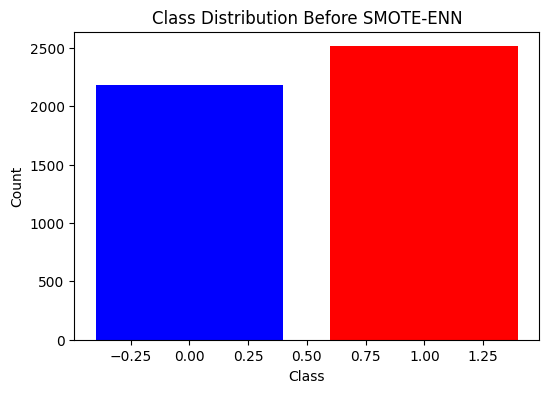

In [ ]:
# Show class distribution before applying SMOTE-ENN
plt.figure(figsize=(6,4))
counts = y.value_counts()
plt.bar(counts.index, counts.values, color=['red', 'blue'])
plt.title("Class Distribution Before SMOTE-ENN")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


In [ ]:
y.value_counts()

,count
treatment,
1,2512
0,2180


In [ ]:
# Apply SMOTE-ENN to handle class imbalance
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
y_resampled = to_categorical(y_resampled)

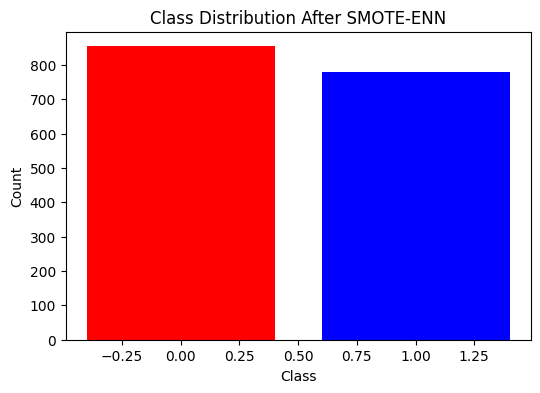

In [ ]:
# Show class distribution after applying SMOTE-ENN
plt.figure(figsize=(6,4))
unique, counts = np.unique(np.argmax(y_resampled, axis=1), return_counts=True)
plt.bar(unique, counts, color=['red', 'blue'])
plt.title("Class Distribution After SMOTE-ENN")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Reshape data for CNN/LSTM compatibility
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [ ]:
# Define CNN model
def create_cnn():
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        Conv1D(64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(y_train.shape[1], activation='softmax')
    ])
    return model



In [ ]:
# Define LSTM model
def create_lstm():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(y_train.shape[1], activation='softmax')
    ])
    return model



In [ ]:
# Define BiLSTM model
def create_bilstm():
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(y_train.shape[1], activation='softmax')
    ])
    return model

In [ ]:
# Combine two models
def create_combined_model(model1, model2):
    input_layer = Input(shape=(X_train.shape[1], 1))
    x1 = model1(input_layer)
    x2 = model2(input_layer)
    merged = concatenate([x1, x2])
    output_layer = Dense(y_train.shape[1], activation='softmax')(merged)
    return Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Training and evaluation
def train_and_evaluate(model, name, epochs):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    acc = model.evaluate(X_test, y_test, verbose=0)[1]
    return acc, history, model

models = {
    'CNN': create_cnn(),
    'LSTM': create_lstm(),
    'BiLSTM': create_bilstm(),
    'CNN+LSTM': create_combined_model(create_cnn(), create_lstm()),
    'LSTM+BiLSTM': create_combined_model(create_lstm(), create_bilstm()),
    'CNN+BiLSTM': create_combined_model(create_cnn(), create_bilstm())
}

epochs_list = [5, 15, 25]
best_model = None
best_accuracy = 0
best_model_name = ""
best_epochs = 0

results = {}

for name, model in models.items():
    for epochs in epochs_list:
        accuracy, history, trained_model = train_and_evaluate(model, name, epochs)
        results[(name, epochs)] = accuracy

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = trained_model
            best_model_name = name
            best_epochs = epochs


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Print results
for key, value in results.items():
    print(f"Model: {key[0]}, Epochs: {key[1]}, Accuracy: {value:.4f}")

Model: CNN, Epochs: 5, Accuracy: 0.7523
Model: CNN, Epochs: 15, Accuracy: 0.9235
Model: CNN, Epochs: 25, Accuracy: 0.9266
Model: LSTM, Epochs: 5, Accuracy: 0.8777
Model: LSTM, Epochs: 15, Accuracy: 0.9266
Model: LSTM, Epochs: 25, Accuracy: 0.9235
Model: BiLSTM, Epochs: 5, Accuracy: 0.8807
Model: BiLSTM, Epochs: 15, Accuracy: 0.8899
Model: BiLSTM, Epochs: 25, Accuracy: 0.9021
Model: CNN+LSTM, Epochs: 5, Accuracy: 0.8440
Model: CNN+LSTM, Epochs: 15, Accuracy: 0.9266
Model: CNN+LSTM, Epochs: 25, Accuracy: 0.9419
Model: LSTM+BiLSTM, Epochs: 5, Accuracy: 0.8869
Model: LSTM+BiLSTM, Epochs: 15, Accuracy: 0.9174
Model: LSTM+BiLSTM, Epochs: 25, Accuracy: 0.9174
Model: CNN+BiLSTM, Epochs: 5, Accuracy: 0.7645
Model: CNN+BiLSTM, Epochs: 15, Accuracy: 0.9174
Model: CNN+BiLSTM, Epochs: 25, Accuracy: 0.9358


In [ ]:
# Save the best model
if best_model:
    best_model.save(f'best_model_{best_model_name}.h5')

# Print the best result
print(f"Best Model: {best_model_name} with {best_epochs} epochs achieving accuracy: {best_accuracy:.4f}")


Best Model: CNN+LSTM with 25 epochs achieving accuracy: 0.9419


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


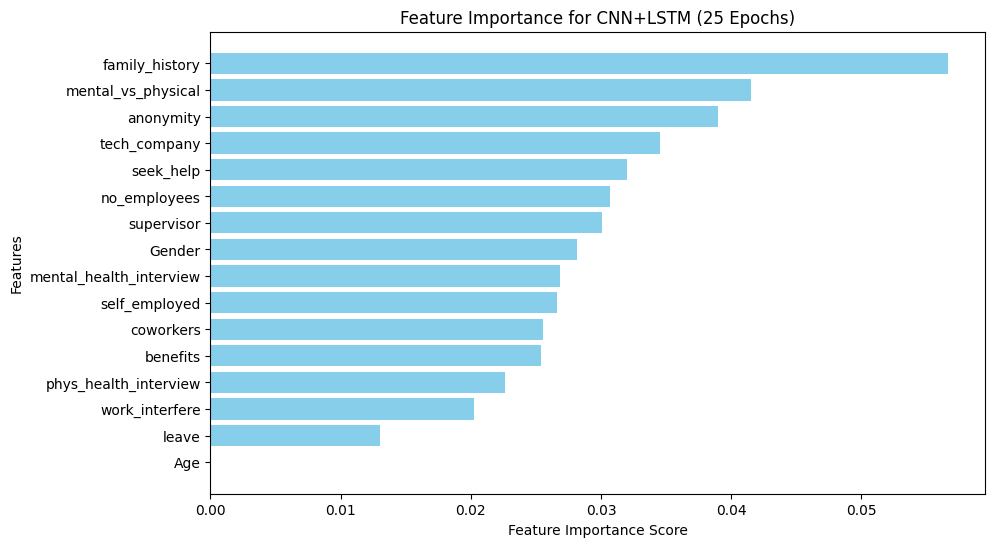

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

# Load the saved best model
best_model = tf.keras.models.load_model("/content/best_model_CNN+LSTM.h5")  # Ensure correct file path


# Extract features and standardize them
X = data.drop(columns=['treatment'])  # Replace 'target' with the actual target column name
feature_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Get feature importance using permutation importance
def get_feature_importance(model, X, feature_names):
    baseline_preds = model.predict(X)
    baseline_loss = np.mean(np.argmax(baseline_preds, axis=1) != np.argmax(baseline_preds, axis=1))

    importances = []
    for i in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])  # Shuffle one feature at a time
        preds = model.predict(X_permuted)
        permuted_loss = np.mean(np.argmax(preds, axis=1) != np.argmax(baseline_preds, axis=1))
        importance = permuted_loss - baseline_loss
        importances.append(importance)

    return np.array(importances)

# Calculate feature importance
feature_importances = get_feature_importance(best_model, X_scaled, feature_names)

# Sort and plot feature importance
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), feature_importances[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(feature_names)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance for CNN+LSTM (25 Epochs)")
plt.gca().invert_yaxis()
plt.show()
